In [1]:
from matplotlib import pylab
import nengo
import numpy as np

%matplotlib inline

In [2]:
STEP = 0.001#s
EQ_MARGIN = 0.0001
SIM_TIME = 1000#s
SWITCH_TIME = 0.500#s
SWITCH_TIME2 = 0.050#s
CHECKS = 45
DIVIDER = 1
SIM_TIME2 = SWITCH_TIME2#s
DIST = 10
D_STEP = 10
def fn(j, vals, vals2, vals3):
    s = SWITCH_TIME
    vs = vals
#    cur = STEP
    i = 0
    #prep yield
    t = yield
    init = t
    cur = init
    #print t
    while True:
    #initial training
        if -EQ_MARGIN <= t-SIM_TIME-init <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            #print '*********************************************'
            cur = t
            i += 1
        t = yield [vs[i], 0, 1]
        #print cur, t, t-cur, s, t-cur-s, -EQ_MARGIN <= t-cur-s <= EQ_MARGIN
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 1
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    s = SWITCH_TIME
    vs = vals3
    cur = t
    resim_time = SIM_TIME/DIVIDER+t
    i = 0
    while True:
    #retraining
        if -EQ_MARGIN <= t-resim_time <= EQ_MARGIN:
            break
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
        t = yield [vs[i], 1, 0.5]
        j.append(vs[i])
    s = SWITCH_TIME2
    vs = vals2
    cur = t
    i = 0
    while True:
    #assessment 2
        if i >= len(vals2):
            print 'too far', t
            break
        t = yield [vs[i], 0, 0]
        j.append(vs[i])
        if -EQ_MARGIN <= t-cur-s <= EQ_MARGIN:
            cur = t
            i += 1
    while True:
        t = yield [0, 0, 0]

In [3]:
model = nengo.Network(seed=3)
dist = nengo.dists.Uniform(-1.0, 1.0)
vals = dist.sample((SIM_TIME/SWITCH_TIME)+1)
vals3 = dist.sample((SIM_TIME/SWITCH_TIME/DIVIDER)+1)
vals2 = np.linspace(-1, 1, CHECKS)
j=[]
func = fn(j, vals, vals2, vals3)
func.next()
func = func.send

In [4]:
#time = int(2*(SIM_TIME/STEP)+3*(CHECKS*SWITCH_TIME2/STEP))
#print time
#a = [func(0.001*x) for x in range(1, time+1)]

In [5]:
#b = np.array(a)
#c = b[:, 0]
#print list(c).index(-1.0)
#print c[2406700:2406750]
#print c.shape

In [6]:
#d = {}
#z=52200
#for a in set(c[:]):
#    d[a] = 0
#for a in c[:]:
#    d[a] += 1
#for k in d:
#    if d[k] != 500 and d[k] != 1500 and d[k] != 50 and d[k] != 150:
#        print k, d[k]
#print c[0], c[499], c[500], c[999], c[1000], c[1499]
#print c[49998], c[49999]
#print c[3501], c[4001], c[1500], c[2000], c[2001]
#print c[52200-1:52250]
#print [i for i, x in enumerate(c[:z]) if -0.01 < x+0.421665933532 < 0.01]

In [7]:
with model:
    stim = nengo.Node(func)
    
    sensory = nengo.Ensemble(n_neurons=400, dimensions=3,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    
    spatial = nengo.Ensemble(n_neurons=400, dimensions=2,
                            intercepts=nengo.dists.Uniform(0.81,0.91))
    
    nengo.Connection(stim, sensory[:],
                     function=lambda x: (np.sin(x[0]*np.pi/2), 
                                         np.cos(x[0]*np.pi/2), 
                                         x[1]))
    
    #nengo.Connection(sensory[:2], sensory[2:], synapse=0.2)
    
    c = nengo.Connection(sensory, spatial, function=lambda x: [0,0],
                         learning_rule_type=nengo.PES(learning_rate=3e-4))
        
    error = nengo.Ensemble(n_neurons=400, dimensions=3)
    
    nengo.Connection(stim[2], error[2])
    nengo.Connection(sensory[:2], error[:2],
                     transform=-1)
    nengo.Connection(error, c.learning_rule, 
                     #0.19 is 17deg shift (need more negative to mitigate it)
                     function=lambda x: x[:2] if x[2] > 0.7 else x[:2]-0.19 if x[2] > 0.3 else [0, 0])
    #nengo.Connection(spatial, c.learning_rule, synapse=0.1)
    
    nengo.Connection(spatial, error[:2])
    #correct = nengo.Node([0,0])
    #nengo.Connection(correct, error, transform=-1)
    
    spatial_probe = nengo.Probe(spatial.neurons)
    


In [8]:
def sim_gen(time, cnt):
    cur = 0
    yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0) #prep
    while cur <= cnt:
        sim.run(time, progress_bar=False)
        yield np.mean(sim.data[spatial_probe][-int(SWITCH_TIME2/STEP):], axis=0)
        #print sim.data[spatial_probe].shape
        cur += 1
        
def calc_norm(rates, rate_peaks=None):
    #assume that cells with similar peak centers would fall under the same
    #multicellular recording therefore peaks are done relative to all values with similar peaks
    nrm_rates = []
    if rate_peaks is None:
        rate_peaks = np.max(rates, axis=1)
        rate_peaks = np.array([p if p > 0 else 1 for p in rate_peaks])
    max_i = np.argmax(rates, axis=0)
    for j, i in enumerate(max_i):
        nrm_rates.append(rates[:, j]/rate_peaks[i])
    nrm_rates = np.array(nrm_rates).transpose()
    return nrm_rates, rate_peaks

def align_cut(nrm, dist, num_checks, maxes=None):
    #below uses the protocol from the paper where the center value of the values with >= 50% of
    #the max value is used as the max
    #cut assumes that it is not multimodal
    if maxes is None:
        cut = [[(i, neuron_val) for i, neuron_val in enumerate(nrm[:, col]) 
                if neuron_val >= 0.5] for col in range(nrm.shape[1])]
        maxes = [(i, neuron_vals[len(neuron_vals)/2][0]) 
                 for i, neuron_vals in enumerate(cut) 
                 if len(neuron_vals) > 0]
    max_cuts = [nrm[mx-dist:mx+dist+1, i] 
                for i, mx in maxes 
                if mx >= dist and mx <= num_checks-(dist+1)]
    return np.array(max_cuts), maxes

def prep_graph(time, cnt, dist):
    sim_g = sim_gen(time, cnt)
    sim_g.next()
    return align_cut(calc_norm(np.array([mean for mean in sim_g])), dist)

def graph_neurons(vals, step):
    for v in range(vals.shape[0]):
        pylab.plot(range(-DIST*step, DIST*step+1, step), vals[v, :])

def graph_mean(mean, step):
    pylab.plot(range(-DIST*step, DIST*step+1, step), mean)
    
def filtered_mean(vals):
    return np.mean([x for x in vals if sum(x) > 0], axis=0)

In [9]:
sim = nengo.Simulator(model)

In [10]:
sim.run(SIM_TIME)

Simulation finished in 0:06:29.                                                 


In [11]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a=sim_g.next()
#print a.shape
mean = np.array([mean for mean in sim_g])
print mean.shape
Y = len(j)
print Y

too far 1002.25
(45, 400)
1002250


In [12]:
n, rate_peaks = calc_norm(mean)

In [13]:
out, maxes = align_cut(n, DIST, len(vals2))
print out.shape
print [len(x) for x in out]
mean_out = np.mean(out, axis=0)
print mean_out.shape

(121, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


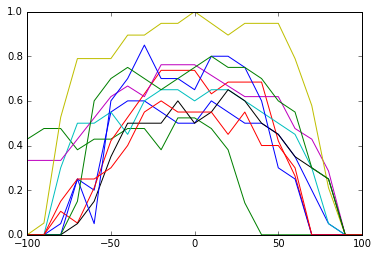

In [14]:
graph_neurons(out[:10], D_STEP)

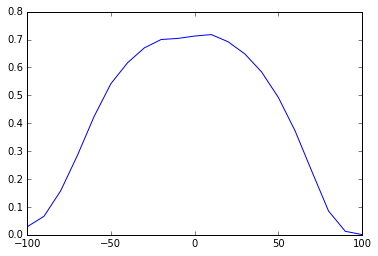

In [15]:
graph_mean(mean_out, D_STEP)

In [16]:
sim.run(SIM_TIME/DIVIDER)

Simulation finished in 0:06:44.                                                 


In [17]:
sim_g = sim_gen(SIM_TIME2, len(vals2)-1)
a2=sim_g.next()
#print a.shape
mean2 = np.array([mean for mean in sim_g])
print mean2.shape

too far 2004.5
(45, 400)


In [18]:
n2, rate_peaks2 = calc_norm(mean2)

In [19]:
#Centered the graphs relative to themselves
out2, maxes2 = align_cut(n2, DIST, len(vals2))
print out2.shape
print [len(x) for x in out2]
mean_out2 = filtered_mean(out2)
print mean_out2.shape

(203, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
(21,)


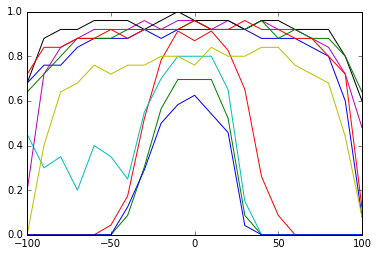

In [20]:
graph_neurons(out2[:10], D_STEP)

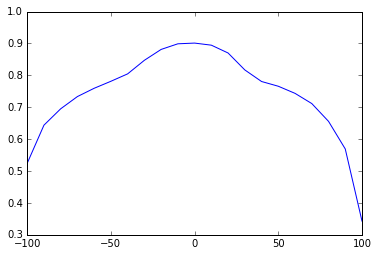

In [21]:
graph_mean(mean_out2, D_STEP)

In [22]:
n3, rate_peaks2 = calc_norm(mean2)

In [23]:
#Centered the graphs relative to the original distribution
out3, maxes3 = align_cut(n3, DIST, len(vals2), maxes)
print out3.shape
print [len(x) for x in out3]
mean_out3 = filtered_mean(out3)
print np.mean([x for x in out3 if sum(x) > 0], axis=1)
print np.sum([x for x in out3 if sum(x) > 0], axis=1)
print mean_out3.shape

(121, 21)
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
[ 0.59619048  0.4152381   0.87809524  0.72571429  0.52380952  0.94285714
  0.80380952  0.67238095  0.67619048  0.74666667  0.80571429  0.76571429
  0.77904762  0.73714286  0.71047619  0.48380952  0.73904762  0.70095238
  0.79809524  0.48214286  0.73142857  0.88761905  0.92952381  0.49142857
  0.59809524  0.92952381  0.71809524  0.41333333  0.78857143  0.60952381
  0.87809524  0.91047619  0.92        0.54666667  0.66285714  0.71238095
  0.77142857  0.49333333  0.79428571  0.5847619   0.91238095  0.657

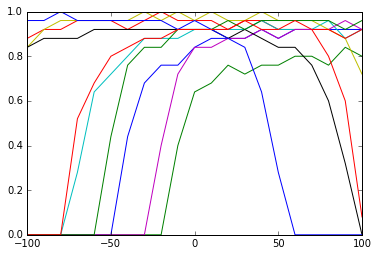

In [24]:
graph_neurons(out3[:10], D_STEP)

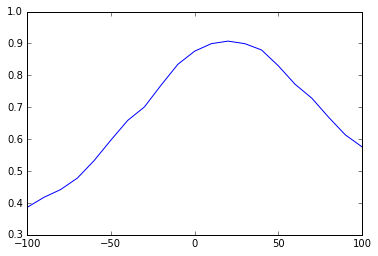

In [25]:
graph_mean(mean_out3, D_STEP)

In [26]:
print len(j)
y = 52250
x = j[y:].index(-1.0)
print x+y
#print j[x:x+10]
d = {}
for a in set(j[:]):
    d[a] = 0
for a in j[:]:
    d[a] += 1
for k in d:
    if d[k] != 500 and d[k] != 1000 and d[k] != 50 and d[k] != 100:
        print k, d[k]
print j[y-55:][:10]
print j[0]
print j[-1]
print sim.data[spatial_probe].shape

2004500
1000000
[0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963, 0.47085489023467963]
0.0450322421561
1.0
(2004500, 400)


In [27]:
print len(j)
print j[-2260:-2240]
print j[-1]
print n2.shape
print np.sum(n2, axis=1)
print np.sum(n2, axis=0)
print n2[:, 2]

2004500
[0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, 0.84976078703585434, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
1.0
(45, 400)
[  20.0845354    23.948627     35.6604119    36.95194508   53.88398169
   58.1423341    51.57894737   32.09874142   26.73081617   45.24183829
   44.79424104   52.88206712   76.31615179   90.18981693   96.93574752
  101.03391304  111.9773913   125.58673913  131.16862319  134.12
  140.27833333  145.49166667  147.50166667  149.31833333  150.60333333
  151.11333333  153.27        153.215       152.25        151.99333333
  146.13333333  137.30333333  128.02636364  114.6013834   100.28401186
   97.1745191    89.22268775   79.21857049   77.83630435   75.11629776
   70.01946452   52.85824487   60.0267269    39.00377564   31.24264822]
[  7.          17.48        11.91666667   3.65217391   6.04347826   7.1
 